In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks/MBA/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/Colab Notebooks/MBA/data/Fake.csv
/content/drive/My Drive/Colab Notebooks/MBA/data/True.csv


In [ ]:
true_data_path = "/content/drive/My Drive/Colab Notebooks/MBA/data/True.csv"
fake_data_path = "/content/drive/My Drive/Colab Notebooks/MBA/data/Fake.csv"

In [ ]:
from nltk.tokenize import word_tokenize
import re
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import numpy as np
import pickle

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [ ]:
true = pd.read_csv(true_data_path)
fake = pd.read_csv(fake_data_path)

true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
true["target"] = 0
fake["target"] = 1

true.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [ ]:
df = pd.concat([true,fake])
df.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [ ]:
print(len(true) + len(fake))
print(len(df))

44898
44898


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,title,text,subject,date,target
6089,Trump makes early move on restricting abortion...,NEW YORK (Thomson Reuters Foundation) - U.S. P...,politicsNews,"January 23, 2017",0
18250,HOLLYWOOD LIBS HAVE EPIC MELT DOWNS…Threaten P...,Hollywood stars took to social media Wednesday...,left-news,"Jul 26, 2017",1
6356,Trump and spy chief differ on what was said in...,WASHINGTON (Reuters) - U.S. spy chief James Cl...,politicsNews,"January 12, 2017",0
15331,"At least four dead, 18 missing in Colombia lan...",BOGOTA (Reuters) - A landslide killed at least...,worldnews,"November 8, 2017",0
14705,"3,000 form chain of light against far right in...","VIENNA (Reuters) - At least 3,000 people forme...",worldnews,"November 15, 2017",0


In [ ]:
# we now have to do the data preprocessing
def basic_text_cleaning(line_from_column):
    # This function takes in a string, not a list or an array for the arg line_from_column
    
    tokenized_doc = word_tokenize(line_from_column)
    
    new_review = []
    for token in tokenized_doc:
        new_token = regex.sub(u'', token)
        if not new_token == u'':
            new_review.append(new_token)
    
    new_term_vector = []
    for word in new_review:
        if not word in stopwords.words('english'):
            new_term_vector.append(word)
    
    final_doc = []
    for word in new_term_vector:
        final_doc.append(wordnet.lemmatize(word))
    
    return ' '.join(final_doc)

def get_dummies(df, col_target):
    df_y = pd.get_dummies(df[col_target])
    df_new = df.join(df_y)
    df_new = df_new.drop(col_target,axis=1)
    return df_new

def prep_features(df, labels, text):
    y = df[labels].values
    comments_train = df[text]
    comments_train = list(comments_train)
    
    return comments_train, y

def prep_tokenizer(texts,MAX_NB_WORDS):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    
    print("Tokeniser created - Saving Tokeniser")
    
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    print("Tokeniser saved")
    
def prepare_training_test_data(texts,tokenizer,y):
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Vocabulary size:', len(word_index))
    
    print("Padding sequences")
    
    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', data.shape)
    
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = y[indices]
    
    num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
    x_train = data[: -num_validation_samples]
    y_train = labels[: -num_validation_samples]
    x_val = data[-num_validation_samples: ]
    y_val = labels[-num_validation_samples: ]
    
    print('Number of entries in each category:')
    print('training: ', y_train.sum(axis=0))
    print('validation: ', y_val.sum(axis=0))
    
    print('Tokenized sentences: \n', data[0])
    print('One hot label: \n', labels[0])
    
    return x_train, y_train, x_val, y_val

In [ ]:
wordnet = WordNetLemmatizer()
regex = re.compile('[%s]' % re.escape(string.punctuation))

In [ ]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 1025 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100   
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [ ]:
df = df[["text","target"]]
df.head()

,text,target
6089,NEW YORK (Thomson Reuters Foundation) - U.S. P...,0
18250,Hollywood stars took to social media Wednesday...,1
6356,WASHINGTON (Reuters) - U.S. spy chief James Cl...,0
15331,BOGOTA (Reuters) - A landslide killed at least...,0
14705,"VIENNA (Reuters) - At least 3,000 people forme...",0


In [ ]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from tqdm import tqdm

tqdm.pandas()

# Assuming that the basic_text_cleaning function is already defined
df["clean_text"] = df["text"].progress_map(basic_text_cleaning)
df.head()




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
100%|██████████| 44898/44898 [28:19<00:00, 26.42it/s]


,text,target,clean_text
6089,NEW YORK (Thomson Reuters Foundation) - U.S. P...,0,NEW YORK Thomson Reuters Foundation US Preside...
18250,Hollywood stars took to social media Wednesday...,1,Hollywood star took social medium Wednesday ex...
6356,WASHINGTON (Reuters) - U.S. spy chief James Cl...,0,WASHINGTON Reuters US spy chief James Clapper ...
15331,BOGOTA (Reuters) - A landslide killed at least...,0,BOGOTA Reuters A landslide killed least four p...
14705,"VIENNA (Reuters) - At least 3,000 people forme...",0,VIENNA Reuters At least 3000 people formed cha...


In [ ]:
import os

# Check if the directory exists, and if not, create it
directory = "models"
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the DataFrame to the CSV file
df.to_csv("models/clean_news.csv")



In [ ]:
df = pd.read_csv(r"models/clean_news.csv")
df["clean_text"]=df["clean_text"].astype(str)

In [ ]:
len(df)


44898

In [ ]:
df_labels =  pd.get_dummies(df["target"])
len(df_labels)


44898

In [ ]:
df_labels = df_labels.reset_index()

In [ ]:
df = df.reset_index()


In [ ]:
df.head()

,index,Unnamed: 0,text,target,clean_text
0,0,6089,NEW YORK (Thomson Reuters Foundation) - U.S. P...,0,NEW YORK Thomson Reuters Foundation US Preside...
1,1,18250,Hollywood stars took to social media Wednesday...,1,Hollywood star took social medium Wednesday ex...
2,2,6356,WASHINGTON (Reuters) - U.S. spy chief James Cl...,0,WASHINGTON Reuters US spy chief James Clapper ...
3,3,15331,BOGOTA (Reuters) - A landslide killed at least...,0,BOGOTA Reuters A landslide killed least four p...
4,4,14705,"VIENNA (Reuters) - At least 3,000 people forme...",0,VIENNA Reuters At least 3000 people formed cha...


In [ ]:
df = df.drop("index",axis=1)

In [ ]:
df.head()

,Unnamed: 0,text,target,clean_text
0,6089,NEW YORK (Thomson Reuters Foundation) - U.S. P...,0,NEW YORK Thomson Reuters Foundation US Preside...
1,18250,Hollywood stars took to social media Wednesday...,1,Hollywood star took social medium Wednesday ex...
2,6356,WASHINGTON (Reuters) - U.S. spy chief James Cl...,0,WASHINGTON Reuters US spy chief James Clapper ...
3,15331,BOGOTA (Reuters) - A landslide killed at least...,0,BOGOTA Reuters A landslide killed least four p...
4,14705,"VIENNA (Reuters) - At least 3,000 people forme...",0,VIENNA Reuters At least 3000 people formed cha...


In [ ]:
df_labels =  pd.get_dummies(df["target"])
df_labels = df_labels.reset_index()
df_labels = df_labels.drop("index",axis=1)
df_labels.head()

,0,1
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


In [ ]:
df_new =df.join(df_labels)

In [ ]:
df_new = get_dummies(df=df, col_target="target")
df_new.head()

,Unnamed: 0,text,clean_text,0,1
0,6089,NEW YORK (Thomson Reuters Foundation) - U.S. P...,NEW YORK Thomson Reuters Foundation US Preside...,1,0
1,18250,Hollywood stars took to social media Wednesday...,Hollywood star took social medium Wednesday ex...,0,1
2,6356,WASHINGTON (Reuters) - U.S. spy chief James Cl...,WASHINGTON Reuters US spy chief James Clapper ...,1,0
3,15331,BOGOTA (Reuters) - A landslide killed at least...,BOGOTA Reuters A landslide killed least four p...,1,0
4,14705,"VIENNA (Reuters) - At least 3,000 people forme...",VIENNA Reuters At least 3000 people formed cha...,1,0


In [ ]:
len(df_new)


44898

In [ ]:
labels = [0,1]
x_train, y_train = prep_features(df=df_new, labels=[0,1], text="clean_text")
print(x_train[0])
print(y_train[0])

NEW YORK Thomson Reuters Foundation US President Donald Trump Monday reinstated global gag rule ban USfunded group around world discussing abortion move widely expected nonetheless dismayed woman ’ right advocate The rule affect American nongovernmental organization working abroad one incoming president used signal position abortion right It created US President Ronald Reagan 1984 Trump abortion opponent signed reinstatement directive ceremony White House fourth day office Former President Barack Obama lifted gag rule 2009 took office “ Women ’ health right one first casualty Trump administration ” said Serra Sippel president Center Health Gender Equity Washington “ The global gag rule associated increase unsafe abortion expect Trump ’ global gag rule cost woman life ” said Reinstatement gag rule formally Mexico City policy come two day crowd people marched city around world show unity woman ’ right among abortion access While official estimate available organizer said nearly five mill

In [ ]:
import os

print("Current working directory:", os.getcwd())

# If the working directory is incorrect, change it using the following command:
os.chdir('/content/drive/My Drive/Colab Notebooks/MBA/data')

Current working directory: /content


In [ ]:
print("Files in the working directory:", os.listdir())

Files in the working directory: ['Fake.csv', 'True.csv', 'tokenizer.pickle']


In [ ]:
!pip install keras_preprocessing


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.5 MB/s eta 0:00:00


In [ ]:
# Import the necessary libraries
from keras_preprocessing.text import Tokenizer
import json

# Sample texts for demonstration purposes
texts = [
    "NEW YORK Thomson Reuters Foundation US President Donald Trumpdismayed woman ’ right advocate The rule affect American nongovernmental organization working abroad one incoming president used signal position abortion right It created US President Ronald Reagan 1984 Trump abortion opponent signed reinstatement directive ceremony White House fourth day office Former President Barack Obama lifted gag rule 2009 took office “ Women ’ health right one first casualty Trump administration ” said Serra Sippel president Center Health Gender Equity Washington .",
    "Another text for demonstration.",
    " Monday reinstated global gag rule ban USfunded group around world discussing abortion move widely expected nonetheless."
]

# Create a tokenizer and fit it on the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Save the tokenizer to a JSON file
tokenizer_config = tokenizer.to_json()
with open('tokenizer.json', 'w') as json_file:
    json_file.write(tokenizer_config)

# Load the tokenizer from the JSON file
from keras_preprocessing.text import tokenizer_from_json

with open('tokenizer.json', 'r') as json_file:
    tokenizer_config = json_file.read()

loaded_tokenizer = tokenizer_from_json(tokenizer_config)

# Test the loaded tokenizer
print(loaded_tokenizer.texts_to_sequences(["he rule affect American nongovernmental organization working abroad one incoming"]))



[[3, 22, 23, 24, 25, 26, 27, 7, 28]]


In [ ]:
x_train,y_train,x_test,y_test = prepare_training_test_data(texts=x_train,tokenizer=tokenizer,y=y_train)


Vocabulary size: 81
Padding sequences
Shape of data tensor: (44898, 200)
Number of entries in each category:
training:  [17165 18754]
validation:  [4252 4727]
Tokenized sentences: 
 [32 46 21 21 67 58 46 46 58 21 46 58 58  7 51  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
One hot label: 
 [0 1]


In [ ]:
embeddings_index = {}
word_index = tokenizer.word_index
GLOVE_DIR = 'glove/glove.6B.100d.txt'
f = open(GLOVE_DIR, encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [ ]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(2, activation="sigmoid")(x)

In [ ]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 100)          8200      
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           38640     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [ ]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 20, batch_size=32, validation_data=(x_test, y_test))

Training progress:
Epoch 1/20
1123/1123 [==============================] - 100s 87ms/step - loss: 0.0310 - accuracy: 0.9929 - val_loss: 0.0086 - val_accuracy: 0.9988
Epoch 2/20
1123/1123 [==============================] - 96s 86ms/step - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.0059 - val_accuracy: 0.9981
Epoch 3/20
1123/1123 [==============================] - 92s 82ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0047 - val_accuracy: 0.9989
Epoch 4/20
1123/1123 [==============================] - 97s 87ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 0.0045 - val_accuracy: 0.9991
Epoch 5/20
1123/1123 [==============================] - 93s 82ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0035 - val_accuracy: 0.9992
Epoch 6/20
1123/1123 [==============================] - 92s 82ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0029 - val_accuracy: 0.9992
Epoch 7/20
1123/1123 [==============================] - 90s 80ms/step - loss: 0.0023 - accuracy: 0.9995 

In [ ]:
model.save("LSTM_model_1.h5")

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("LSTM_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
import matplotlib.pyplot as plt

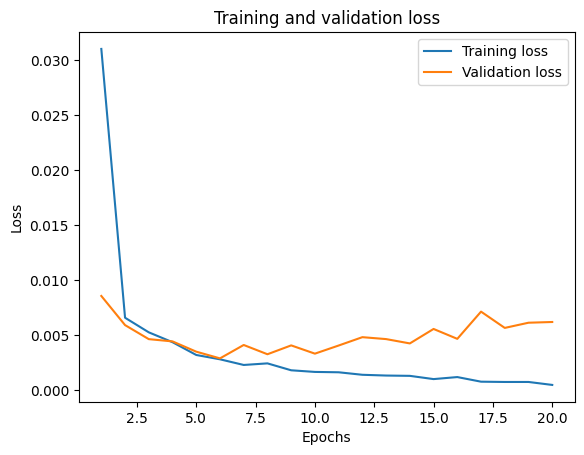

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [ ]:
def predict(model,i):
    clean_text =[]
    i = basic_text_cleaning(i)
    clean_text.append(i)
    sequences = tokenizer.texts_to_sequences(clean_text)
    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
    pred = model.predict(data)
    return pred

In [ ]:
test = "Facebook Inc will allow employees participating in the protest to take the time off without drawing down their vacation days, spokesman Andy Stone said. Separately, online therapy company Talkspace said it ended partnership discussions with Facebook. Talkspace CEO Oren Frank tweeted he would “not support a platform that incites violence, racism, and lies.”"


In [ ]:
!pip install rarfile


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import rarfile

rar_path = "/content/drive/My Drive/Colab Notebooks/MBA/data/models.rar"
with rarfile.RarFile(rar_path) as rf:
    rf.extractall("/content/drive/My Drive/Colab Notebooks/MBA/data/")


In [ ]:
model_new = load_model("/content/drive/My Drive/Colab Notebooks/MBA/data/new_model2.h5")
prediction = predict(model=model_new, i=test)[0][0]


1/1 [==============================] - 0s 65ms/step


In [ ]:
model.predict(x_test)

281/281 [==============================] - 7s 24ms/step


array([[1.0000000e+00, 1.5475643e-14],
       [1.0000000e+00, 3.0996967e-14],
       [9.9999911e-01, 1.1228982e-06],
       ...,
       [9.9999982e-01, 2.4422403e-07],
       [9.7781566e-08, 9.9999994e-01],
       [7.3679790e-10, 1.0000000e+00]], dtype=float32)

In [ ]:
x_test[2]

array([15, 69, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [ ]:
y_classes = predict(model=model,i=test).argmax(axis=-1)

1/1 [==============================] - 0s 33ms/step


In [ ]:
y_classes[0]

0

In [ ]:
from tensorflow.keras.models import load_model
model_new = load_model("new_model2.h5")